In [1]:
# Shiyi (Amy) Qin and Victor Z
# UW-Madison, 2019
# sparse PCA estimation for Gibbs reactor

## Start here if working on google collab

---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Specify the path of this file (This may differ for each user)
path = '/content/drive/MyDrive/StatsBookCode/Python/'

In [4]:
# This is to check if the speficied path above is correct
!echo $path
import os
os.path.isdir(path)

/content/drive/MyDrive/StatsBookCode/Python/


True

In [5]:
# This is needed so we can import packages from a different path than standard libraries
import sys
sys.path.append(path)

## Start from here if working on local computer

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, eig
from sklearn.decomposition import SparsePCA

In [7]:
# Load the datasets
datat = np.loadtxt(path+'Data/gibbs_covariance.dat')
datan = np.loadtxt(path+'Data/gibbs_lowtemp_class.dat')
data = np.hstack((datat, datan[:, [0]]))

In [8]:
# Perturb data with noise
seed = 2024
np.random.seed(seed)  # For reproducibility
S, n = data.shape
data[:, 1] += np.random.normal(0, 0.05, S)

In [9]:
# Construct input-output matrices
Y = data[:, 1]
X = data[:, [0, 2, 3, 4, 5]]
X = np.hstack((X, np.ones((S, 1))))  # Add ones to introduce bias parameter

In [10]:
# Apply PCA estimation
Sigma = X.T @ X
lam, W = eig(Sigma)
idx = lam.argsort()[::-1]
lam = lam[idx]
W = W[:, idx]

# Eliminate small eigenvalues
n1 = 3
W1 = W[:, :n1]
L1 = np.diag(lam[:n1])

# Project input data
T1 = X @ W1

# Estimate parameters
gamma = inv(T1.T @ T1) @ (T1.T @ Y)
thetan = W1 @ gamma
Yhatn = X @ thetan
en = Yhatn - Y
SSE = np.mean(en**2)
sig2 = np.var(en)
Covthetan = sig2 * (W1 @ inv(L1) @ W1.T)
diag_Covthetan = np.diag(Covthetan)

In [11]:
# Apply sparse PCA estimation
num_comp = 6  # number of principal components
sparse_pca = SparsePCA(n_components=num_comp, alpha=1, random_state=seed)
sparse_pca.fit(X)
dense_components = sparse_pca.components_
for i, component in enumerate(dense_components):
    non_zero_indices = np.where(component != 0)[0]
    print(f"Component {i+1} uses variables: {non_zero_indices}")

Component 1 uses variables: []
Component 2 uses variables: [0]
Component 3 uses variables: []
Component 4 uses variables: [1 2 3]
Component 5 uses variables: []
Component 6 uses variables: [0]


In [12]:
# Do estimation again eliminating variables recommended by sparse PCA
Xtmp = X.copy()
X = X[:, [1, 3, 5]]

theta = inv(X.T @ X) @ (X.T @ Y)
Yhat = X @ theta
e = Yhat - Y
SSE = np.mean(e**2)
sig2 = np.var(e)
Covtheta = sig2 * inv(X.T @ X)
diag_Covtheta = np.diag(Covtheta)

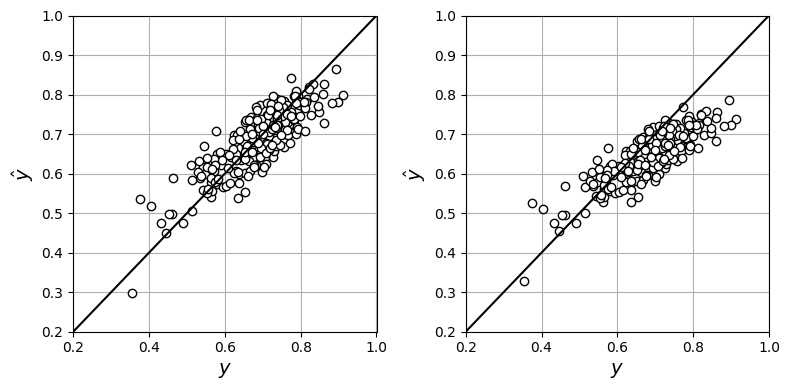

In [14]:
# Compare predictions and observations
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
xx = np.linspace(0, 1)

ax[0].plot(Y, Yhatn, 'ko', markerfacecolor='w')
ax[0].plot(xx, xx, 'k')
ax[0].grid(True)
ax[0].set_xlabel('$y$', fontsize=14)
ax[0].set_ylabel('$\\hat{y}$', fontsize=14)
ax[0].set_xlim(0.2, 1)
ax[0].set_ylim(0.2, 1)

ax[1].plot(Y, Yhat, 'ko', markerfacecolor='w')
ax[1].plot(xx, xx, 'k')
ax[1].grid(True)
ax[1].set_xlabel('$y$', fontsize=14)
ax[1].set_ylabel('$\\hat{y}$', fontsize=14)
ax[1].set_xlim(0.2, 1)
ax[1].set_ylim(0.2, 1)

plt.tight_layout()


In [15]:
print("Standard Estimation Results")
print("Theta:", theta)
print("SSE:", SSE)
print("Variance of errors:", sig2)
print("Covariance of theta:", diag_Covtheta)
print("Eigenvalues:", lam)

print("\nSparse PCA Estimation Results")
print("Theta (PCA):", thetan)
print("SSE (PCA):", SSE)
print("Variance of errors (PCA):", sig2)
print("Covariance of theta (PCA):", diag_Covthetan)

Standard Estimation Results
Theta: [-0.0008553   0.00760044  0.15294429]
SSE: 0.004290192405273677
Variance of errors: 0.002781605987843446
Covariance of theta: [-8.15575501e+05 -8.15575501e+05 -8.15575501e+09]
Eigenvalues: [ 1.45431359e+08  2.36221615e+05  1.97390155e+03  2.23081714e-10
 -4.35075013e-12 -4.24633048e-08]

Sparse PCA Estimation Results
Theta (PCA): [ 2.12745187e-04 -2.20672795e-03 -2.44726841e-03  2.69827483e-03
  2.86645559e-03  4.91546873e-06]
SSE (PCA): 0.004290192405273677
Variance of errors (PCA): 0.002781605987843446
Covariance of theta (PCA): [3.32127090e-07 1.84185366e-07 2.59360199e-07 2.66761424e-07
 2.59620662e-07 7.63446649e-13]
